In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from scipy.stats import multivariate_normal
from sklearn.neighbors import KernelDensity

from sklearn import datasets

# Exercício 1
Considerando a base de dados Vehicle, encontre o melhor classificador dentre os métodos k-vizinhos, Naive Bayes, regressão logística, classificador Bayesiano e classificador Bayesino não-paramétrico

In [17]:
def bestKNN_accuracy(x_train, x_test, y_train, y_test):
  k = 5
  nkf = 5
  vk = []
  vscore = []

  for k in range(1, 20):
    model = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
    cv = cross_validate(model, x_train, y_train, cv = nkf)
    vscore.append(cv['test_score'].mean())
    vk.append(k)

  best_k = np.argmax(vscore) + 1
  
  model = KNeighborsClassifier(n_neighbors = best_k, metric = 'euclidean')
  model.fit(x_train, y_train)

  y_pred = model.predict(x_test)

  return accuracy_score(y_pred, y_test)

In [18]:
def NaiveBayes_accuracy(x_train, x_test, y_train, y_test):

  model1 = GaussianNB()
  model1.fit(x_train, y_train)

  y_pred1 = model1.predict(x_test)

  model2 = BernoulliNB()
  model2.fit(x_train, y_train)

  y_pred2 = model2.predict(x_test)

  accuracy_Gaussian = accuracy_score(y_pred1, y_test)
  accuracy_Bernoulli = accuracy_score(y_pred2, y_test)  
  
#  print("Gaussian Naive Bayes = ", accuracy_Gaussian)
#  print("Bernoulli Naive Bayes = ", accuracy_Bernoulli)

  if(accuracy_Gaussian > accuracy_Bernoulli):
    return "(Gaussian)", accuracy_Gaussian
  return "(Bernoulli)", accuracy_Bernoulli

In [19]:
def LogisticRegression_accuracy(x_train, x_test, y_train, y_test):
  model = LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  return model.score(x_test, y_test)

In [67]:
def BayesClassifier_accuracy(data, x_train, x_test, y_train, y_test, classes, classes_dt_type):

  p = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 

  pc = np.zeros(len(classes)) 

  for i in np.arange(0, len(classes)):
    
    elements = tuple(np.where(y_train == classes_dt_type(classes[i])))
    pc[i] = len(elements)/len(y_train)
    
    z = x_train[elements,:][0]
    m = np.mean(z, axis = 0)
    cv = np.cov(np.transpose(z))

    for j in np.arange(0,x_test.shape[0]):
      x = x_test[j,:]
      
      pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
      
      p[classes[i]][j] = pj * pc[i]

  y_pred = []
  
  for i in np.arange(0, x_test.shape[0]):
      c = np.argmax(np.array(p.iloc[[i]]))
      y_pred.append(classes[c])
  y_pred = np.array(y_pred, dtype=classes_dt_type)

  acc = accuracy_score(y_pred, y_test)

  return acc

In [21]:
def BayesNotParametric_accuracy(data, x_train, x_test, y_train, y_test, h, classes_dt_type):
  
  p = pd.DataFrame(data=np.zeros((x_train.shape[0], len(classes))), columns = classes)
  pc = np.zeros(len(classes))

  for i in np.arange(0, len(classes)):
      elements = tuple(np.where(y_train == classes_dt_type(classes[i])))
      pc[i] = len(elements) / len(y_train)
      z = x_train[elements, :][0]
      kde = KernelDensity(kernel = 'gaussian', bandwidth=h).fit(z)
      for j in np.arange(0, x_test.shape[0]):
        x = x_test[j, :]
        x = x.reshape((1, len(x)))
        pj = np.exp(kde.score_samples(x))
        p[classes[i]][j] = pj * pc[i]

  y_pred = []

  for i in np.arange(0, x_test.shape[0]):
    c = np.argmax(np.array(p.iloc[[i]]))
    y_pred.append(classes[c])
  
  y_pred = np.array(y_pred, dtype = classes_dt_type)
  score = accuracy_score(y_pred, y_test)
  return score

In [68]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Introdução à Ciência de Dados/data/Vehicle.csv", header = (0))

data = data.dropna(axis = 'rows')

classes = np.array(pd.unique(data[data.columns[-1]]), dtype = str)

nrow, ncol = data.shape
attributes = list(data.columns)
data = data.to_numpy()

nrow,ncol = data.shape

y = data[:,-1]
X = data[:,0:ncol-1]

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

p = 0.6
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

In [ ]:
knn = bestKNN_accuracy(x_train, x_test, y_train, y_test)
nv_acc = NaiveBayes_accuracy(x_train, x_test, y_train, y_test)
sigmoid = LogisticRegression_accuracy(x_train, x_test, y_train, y_test)
bayes = BayesClassifier_accuracy(data, x_train, x_test, y_train, classes, y_test, str)

# Chooses best h value.
v_accuracy = []
v_h = np.linspace(0.1, 5, 10)
for h in v_h:
  v_accuracy.append(BayesNotParametric_accuracy(data, x_train, x_test, y_train, y_test, h, str))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: ignored

In [24]:
print("KNN = ", knn)
print("Naive Bayes = ", nv_acc[1], nv_acc[0])
print("Logistic regression = ", sigmoid)
print("Bayesian Classifier = ", bayes)
print("Classificado Bayesiano não paramétrico = ", np.max(v_accuracy))

KNN =  0.6814159292035398
Naive Bayes =  0.46607669616519176 (Bernoulli)
Logistic regression =  0.7964601769911505
Bayesian Classifier =  0.8790560471976401
Classificado Bayesiano não paramétrico =  0.7227138643067846


O classificado Bayesiano paramétrico é o melhor para essa métrica.

# Exercício 2
Considerando a base de dados “winequality-red”, encontre o valor do hiperparâmetro $h$ que oferece a maior acurácia no Bayesino não-paramétrico.

In [41]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Introdução à Ciência de Dados/data/winequality-red.csv", header = (0))

data = data.dropna(axis = 'rows')
classes = np.array(pd.unique(data[data.columns[-1]]), dtype = str)

data = data.to_numpy()
nrow, ncol = data.shape

y = data[:, -1]
X = data[:, 0:ncol - 1]

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

p = 0.6
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

v_accuracy = []
v_h = np.linspace(0.1, 5, 100)
for h in v_h:
  v_accuracy.append(BayesNotParametric_accuracy(data, x_train, x_test, y_train, y_test, h, int))

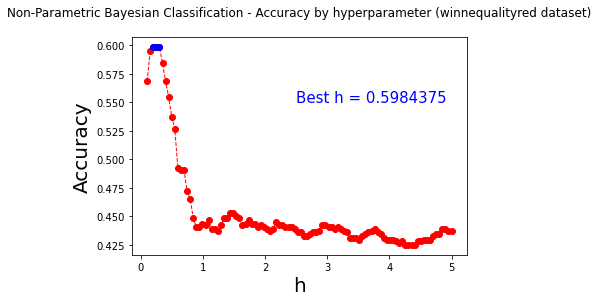

In [43]:
plt.plot(v_h, v_accuracy, 'o--', color = 'red', linewidth=1)

y_tmp = np.where(np.max(v_accuracy) == v_accuracy)[0]
x_max = v_h[y_tmp]
y_max = np.zeros(len(y_tmp))
for i in range(len(y_tmp)):
  y_max[i] = v_accuracy[y_tmp[i]]
plt.plot(x_max, y_max, 'o', color = 'blue')
plt.xlabel("h",fontsize = 20) 
plt.ylabel("Accuracy", fontsize = 20) 

plt.title("Non-Parametric Bayesian Classification - Accuracy by hyperparameter (winnequalityred dataset)\n")

string = "Best h = " + str(np.max(v_accuracy))
plt.text(2.5, .55, string, fontsize=15, color='blue')

plt.show()

# Exercício 3
Faça a classificação dos dados gerados artificialmente com o código abaixo. Compare os resultados para os métodos Naive Bayes, Classificador Bayesiano paramétrico e o classificador Bayesiano não-paramétrico (escolha um valor para h).

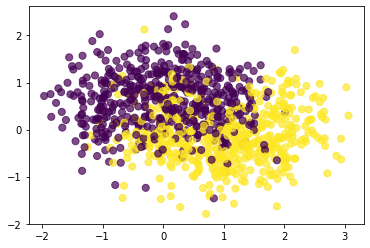

In [57]:
plt.figure(figsize=(6,4))
n_samples = 1000 
data = datasets.make_moons(n_samples=n_samples, noise=.5)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show()

In [ ]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

p = 0.8
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

In [62]:
classes = [0, 1]

In [52]:
bayes = BayesClassifier_accuracy(data, x_train, x_test, y_train, y_test, classes, int)

Elements =  (array([], dtype=int64),)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Degrees of freedom <= 0 for slice
  from ipykernel import kernelapp as app


ValueError: ignored

In [38]:
print("Acurácia para cada método de classificação")
nv_acc = NaiveBayes_accuracy(x_train, x_test, y_train, y_test)
print("Naive Bayes = ", nv_acc[1], nv_acc[0])
print("Classificado Bayesiano = ", BayesClassifier_accuracy(data, x_train, x_test, y_train, y_test, int))
print("Classificado Bayesiano não paramétrico = ", BayesNotParametric_accuracy(data, x_train, x_test, y_train, y_test, 0.45, int))

Acurácia para cada método de classificação
Naive Bayes =  0.79 (Gaussian)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Degrees of freedom <= 0 for slice
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: ignored